In [1]:
import torch
import numpy as np
# from sklearn.linear_model import Ridge
from himalaya.ridge import Ridge, RidgeCV
from himalaya.backend import set_backend
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cpu")
import matplotlib.pyplot as plt

In [ ]:

NSD_train_data = np.load("/decoding_NSD/data_fmri_nsd/train_data.npy")
NSD_train_data = torch.from_numpy(NSD_train_data).to(device)

NSD_test_data = np.load("/decoding_NSD/data_fmri_nsd/test_data.npy")
NSD_test_data = torch.from_numpy(NSD_test_data).to(device)

NSD_train_img_embeds = torch.load("/decoding_NSD/data_fmri_nsd/train_clip_img_embeds.pt", map_location=device)
NSD_test_img_embeds = torch.load("/decoding_NSD/data_fmri_nsd/test_clip_img_embeds.pt", map_location=device)

# NSD_train_img_embeds = NSD_train_img_embeds[:, 1, 0].float()
# NSD_test_img_embeds = NSD_test_img_embeds[:, 1, 0].float()



In [26]:

X_train = NSD_train_img_embeds[:8859].numpy()

X_test = NSD_test_img_embeds[:982].numpy()

Y_train= NSD_train_data[:8859].numpy()
Y_test = NSD_test_data[:982].numpy()

In [27]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8859, 2, 1, 1280), (982, 2, 1, 1280), (8859, 15724), (982, 15724))

In [ ]:
set_backend("torch_cuda")

ridge = Ridge(alpha=50000.0) 
ridge.fit(X_train, Y_train)

Y_pred = ridge.predict(X_test)


r2 = r2_score(Y_test, Y_pred, multioutput='uniform_average')
print(f"R² Score on Test Data: {r2:.4f}")


voxel_correlations = np.array([
    pearsonr(Y_test[:, v], Y_pred[:, v])[0] if np.std(Y_test[:, v]) > 0 else 0 for v in range(Y_test.shape[1])])


mean_voxel_corr = np.median(voxel_correlations)
print(f"Median Voxel-wise Correlation: {mean_voxel_corr:.4f}")

In [ ]:
res  = ((Y_test-Y_pred.numpy())**2).mean(0)

(array([  56.,  151.,  251.,  509., 1404., 3348., 6441., 3301.,  252.,
          11.]),
 array([0.3030724 , 0.39773792, 0.49240344, 0.58706896, 0.68173448,
        0.7764    , 0.87106552, 0.96573104, 1.06039656, 1.15506208,
        1.2497276 ]),
 <BarContainer object of 10 artists>)

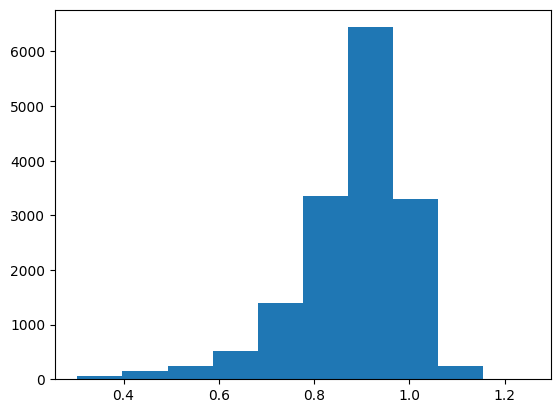

In [ ]:
plt.hist(res)

(array([ 375., 2171., 2866., 3344., 2964., 2010., 1132.,  465.,  302.,
          95.]),
 array([-0.07180726,  0.01991797,  0.1116432 ,  0.20336842,  0.29509365,
         0.38681888,  0.4785441 ,  0.57026933,  0.66199456,  0.75371979,
         0.84544501]),
 <BarContainer object of 10 artists>)

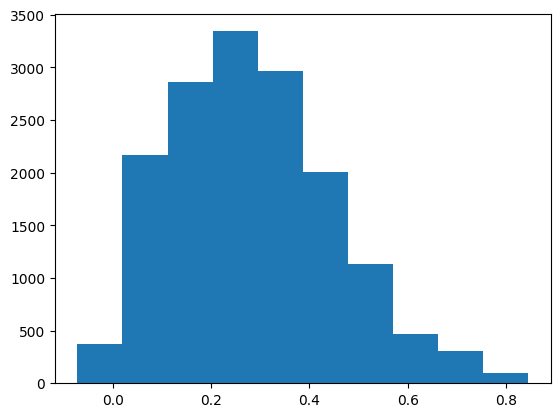

In [ ]:
plt.hist(voxel_correlations)

In [ ]:
aug_image_embds = torch.load("/decoding_NSD/data_augmentation/image_embeddings.pt")
aug_image_embds = aug_image_embds[:, 1, 0].float()

aug_image_embds.shape

torch.Size([8859, 1280])

In [ ]:
subj2_pred = ridge.predict(aug_image_embds)

In [ ]:
subj2_pred.shape

torch.Size([8859, 15724])

In [ ]:
from scipy.stats import rv_histogram

# Example histogram data (assuming a histogram was computed)
hist_data = np.histogram(res, bins=5, density=True)

# Create a continuous distribution from the histogram
hist_dist = rv_histogram(hist_data)

# Sample from the distribution
samples = hist_dist.rvs(size=subj2_pred.shape)
print(samples.mean())
print(samples.std())


noise_scale = 1.0


subj1_pred_noise = subj2_pred + samples*noise_scale

0.8859185153628758
0.13864843202948068


In [ ]:
subj1_pred_noise.shape

torch.Size([8859, 15724])

In [ ]:
torch.save(subj1_pred_noise, "/decoding_NSD/data_augmentation/100_percent/subject1.pt")

In [ ]:
# import torch
# import torchvision.transforms as transforms
# from torchvision.datasets import ImageFolder
# from torch.utils.data import DataLoader, Subset
# import random
# import os


# dataset_path = "/imageNet/ilsvrc2012/versions/1"  
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  
#     transforms.ToTensor(),         
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
# ])


# dataset = ImageFolder(root=dataset_path, transform=transform)


# random_indices = random.sample(range(len(dataset)), 8859)


# subset = Subset(dataset, random_indices)


# dataloader = DataLoader(subset, batch_size=64, shuffle=False)  # Adjust batch size as needed


# image_tensors = []
# for images, _ in dataloader:
#     image_tensors.append(images)


# final_tensor = torch.cat(image_tensors, dim=0)  # Shape: (8859, 3, 224, 224)


# torch.save(final_tensor, "/decoding_NSD/data_augmentation/selected_images.pt")



In [ ]:
subj1_aug = torch.load("/decoding_NSD/data_augmentation/100_percent/subject1.pt")
subj5_aug = torch.load("/decoding_NSD/data_augmentation/100_percent/subject3.pt")
subj2_aug = torch.load("/decoding_NSD/data_augmentation/100_percent/subject2.pt")
subj7_aug = torch.load("/decoding_NSD/data_augmentation/100_percent/subject4.pt")


In [4]:
subj1 = NSD_train_data[:8859]
subj2 = NSD_train_data[8859:17718]
subj5 = NSD_train_data[17718:26577]
subj7 = NSD_train_data[26577:35436]

In [30]:
subject1 = torch.cat((subj1, subj1_aug), dim=0)
subject2 = torch.cat((subj2, subj2_aug), dim=0)
subject5 = torch.cat((subj5, subj5_aug), dim=0)
subject7 = torch.cat((subj7, subj7_aug), dim=0)

subject1.shape, subject2.shape, subject5.shape, subject7.shape

(torch.Size([17718, 15724]),
 torch.Size([17718, 15724]),
 torch.Size([17718, 15724]),
 torch.Size([17718, 15724]))

In [31]:
train_25percent_noise_10 = torch.cat((subject1, subject2, subject5, subject7), dim=0)

In [32]:
train_25percent_noise_10.shape

torch.Size([70872, 15724])

In [ ]:
torch.save(train_25percent_noise_10, "/decoding_NSD/data_augmentation/train_100percent_noise_100.pt")

In [9]:
subj1_image_embds = NSD_train_img_embeds[:8859]
subj2_image_embds = NSD_train_img_embeds[8859:17718]
subj5_image_embds = NSD_train_img_embeds[17718:26577]
subj7_image_embds= NSD_train_img_embeds[26577:35436]

In [ ]:
aug_image_embds = torch.load("/decoding_NSD/data_augmentation/image_embeddings.pt").to(device)

In [11]:
subj1_image_embds = torch.cat((subj1_image_embds, aug_image_embds), dim=0)
subj2_image_embds = torch.cat((subj2_image_embds, aug_image_embds), dim=0)
subj5_image_embds = torch.cat((subj5_image_embds, aug_image_embds), dim=0)
subj7_image_embds= torch.cat((subj7_image_embds, aug_image_embds), dim=0)

train_img_embeds = torch.cat((subj1_image_embds, subj2_image_embds, subj5_image_embds, subj7_image_embds), dim=0)

train_img_embeds.shape

torch.Size([70872, 2, 1, 1280])

In [ ]:
torch.save(train_img_embeds, "/decoding_NSD/data_augmentation/train_embds_100percent.pt")

In [ ]:

subject_ids = []


subject_ids.extend([1] * 17718)  
subject_ids.extend([2] * 17718)  
subject_ids.extend([5] * 17718) 
subject_ids.extend([7] * 17718) 


subject_ids_tensor = torch.tensor(subject_ids)
torch.save(subject_ids, "/decoding_NSD/data_augmentation/train_ids_100percent.pt")

subject_ids_tensor

tensor([1, 1, 1,  ..., 7, 7, 7])

In [ ]:
subject_ids_tensor.shape

torch.Size([17720])